In [1]:
from IPython.core.display import display
import preprocessing
import ember_net
import plots
import evaluation
import adverserial_gen
import os
import gc
import torch
import torch.optim as optim
import torch.nn.functional as F
import tqdm
from torchinfo import summary
import time

In [2]:
# run this if you made some changes in the python files while notebook kerel was running
import importlib
importlib.reload(preprocessing)
importlib.reload(ember_net)
importlib.reload(plots)
importlib.reload(evaluation)
importlib.reload(adverserial_gen)


<module 'adverserial_gen' from '/src/final_project_git/adverserial_gen.py'>

In [3]:
compute_mode = 'gpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu' and torch.cuda.is_available():
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

In [4]:
# some meta parameters
lr = 0.0005
batch_size = 100
path = 'model/EmberNetRobust'

In [5]:
# load the data and put it into a pytorch dataloader.
# You can set debug_fragment to a float between 0 and 1 to only use a fraction of the data for debugging
train_loader, val_loader, adv_loader, test_loader, scaler = \
    preprocessing.pipeline("ember2018" , 'model/', batch_size = batch_size, debug_fragment = None, collect_hashes=False)

Reading 600000 samples from training set 
Reading 200000 samples from test set
Samples in training set: 539400
Samples in validation set: 60000
Samples in adverserial set: 600
Samples in test set: 200000 


In [6]:
# initialize the model and optimizer
model = ember_net.EmberNet(device, scaler)
summary(model, (batch_size, 1, 2381))
opt = optim.Adam(model.parameters(), lr=lr,amsgrad=True) 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [100, 128, 37]            8,320
├─BatchNorm1d: 1-2                       [100, 128, 37]            256
├─Dropout: 1-3                           [100, 128, 37]            --
├─Conv1d: 1-4                            [100, 128, 18]            49,280
├─BatchNorm1d: 1-5                       [100, 128, 18]            256
├─Dropout: 1-6                           [100, 128, 18]            --
├─Linear: 1-7                            [100, 256]                590,080
├─BatchNorm1d: 1-8                       [100, 256]                512
├─Dropout: 1-9                           [100, 256]                --
├─Linear: 1-10                           [100, 32]                 8,224
├─BatchNorm1d: 1-11                      [100, 32]                 64
├─Linear: 1-12                           [100, 2]                  66
Total params: 657,058
Trainable params: 657,058
Non-trainable param

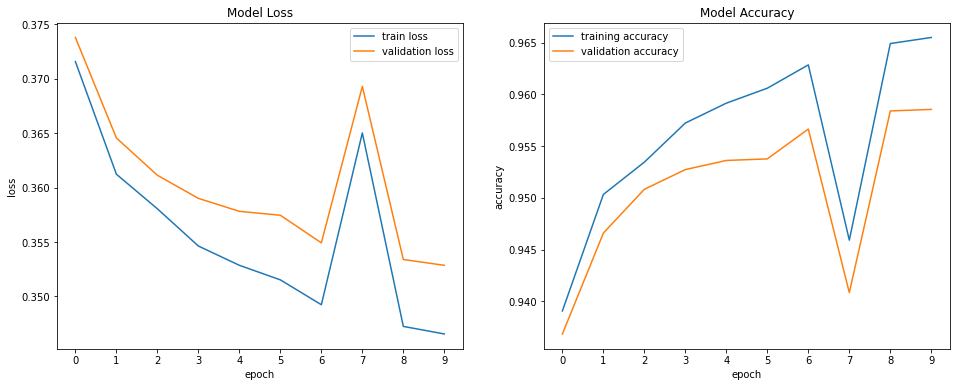

In [7]:
# only execute this cell if you want to load a pretrained model.
# you can continue training on a pretrained model or just evaluate the model
# the saved model should have been trained with the same model architecture as "model"!
model.load(path)
model.plot()

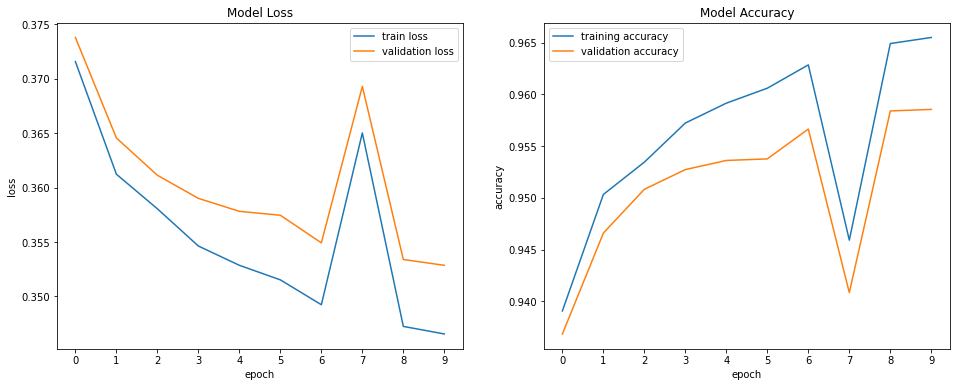

Epoch 9:	 Train Loss= 0.3465507924556732	 Train Accuracy= 0.9655005561735261	 Validation Loss= 0.35286015272140503	 Validation Accuracy= 0.95855


In [7]:
# execute this cell to train the model. Note that the paths to save the model will be overwritten
# you can reevaluate the cell to continue training on the model which is in memory
model.load('model/tmp')
model.fit(epochs=10, loss_func= F.cross_entropy, opt=opt, train_dl=train_loader, valid_dl=val_loader, save_path='model/tmp', epsilon=2.5)
model.save(path)

In [8]:
start_time = time.time()
model.test(F.cross_entropy, test_loader)
end_time = time.time()

print ('Prediction Time',round(end_time-start_time,2) )

Test Loss= 0.36190205812454224	 Test Accuracy= 0.950125
Prediction Time 9.69


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.341075599193573	 Adverserial Accuracy= 0.97


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3548043370246887	 Adverserial Accuracy= 0.9533333333333334


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3588699996471405	 Adverserial Accuracy= 0.95


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3557184338569641	 Adverserial Accuracy= 0.9466666666666667


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3445873558521271	 Adverserial Accuracy= 0.97


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.33745139837265015	 Adverserial Accuracy= 0.9766666666666667


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3357831537723541	 Adverserial Accuracy= 0.98


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3348299264907837	 Adverserial Accuracy= 0.98


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.33374011516571045	 Adverserial Accuracy= 0.98


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3326336741447449	 Adverserial Accuracy= 0.98


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3454264998435974	 Adverserial Accuracy= 0.965


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3551492393016815	 Adverserial Accuracy= 0.955


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3579975366592407	 Adverserial Accuracy= 0.9533333333333334


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.35569947957992554	 Adverserial Accuracy= 0.9516666666666667


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3467978537082672	 Adverserial Accuracy= 0.965


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3417229950428009	 Adverserial Accuracy= 0.9716666666666667


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.34144872426986694	 Adverserial Accuracy= 0.9733333333333334


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3416910767555237	 Adverserial Accuracy= 0.9733333333333334


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3426760733127594	 Adverserial Accuracy= 0.9716666666666667


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3438657522201538	 Adverserial Accuracy= 0.9683333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 0.3454264998435974	 Adverserial Accuracy= 0.965


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 1.148006558418274	 Adverserial Accuracy= 0.15333333333333332


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 1.2338099479675293	 Adverserial Accuracy= 0.07333333333333333


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 1.2379683256149292	 Adverserial Accuracy= 0.07


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 1.217756986618042	 Adverserial Accuracy= 0.08333333333333333


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 1.1949188709259033	 Adverserial Accuracy= 0.10166666666666667


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 1.1816474199295044	 Adverserial Accuracy= 0.12666666666666668


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 1.1717602014541626	 Adverserial Accuracy= 0.135


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 1.155066967010498	 Adverserial Accuracy= 0.15333333333333332


  0%|          | 0/6 [00:00<?, ?it/s]

Original Loss= 0.3454264998435974	 Original Accuracy= 0.965	 Adverserial Loss= 1.1422113180160522	 Adverserial Accuracy= 0.165


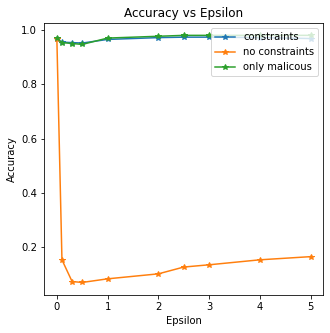

In [8]:
epsilons = [0,0.1,0.3,0.5,1,2,2.5,3,4,5]
accuracies_mask = []
accuracies = []
accuracies_mal = []
examples_mask = []
examples = []

for eps in tqdm.auto.tqdm(epsilons):
    gc.collect()
    if compute_mode=="gpu":
        torch.cuda.empty_cache()
    _, acc = model.attack(F.cross_entropy, eps, adv_loader, constraints=True, malicous_only=True)
    accuracies_mal.append(acc)

for eps in tqdm.auto.tqdm(epsilons):
    gc.collect()
    if compute_mode=="gpu":
        torch.cuda.empty_cache()
    example, acc = model.attack(F.cross_entropy, eps, adv_loader, constraints=True)
    accuracies_mask.append(acc)
    examples_mask.append(example)

for eps in tqdm.auto.tqdm(epsilons):
    gc.collect()
    if compute_mode=="gpu":
        torch.cuda.empty_cache()
    example, acc = model.attack(F.cross_entropy, eps, adv_loader)
    accuracies.append(acc)
    examples.append(example)
    
plots.plot_eps_acc(epsilons, accuracies_mask, accuracies, accuracies_mal)

In [9]:
norms_mask = evaluation.norms(examples_mask)
norms_no_mask = evaluation.norms(examples)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

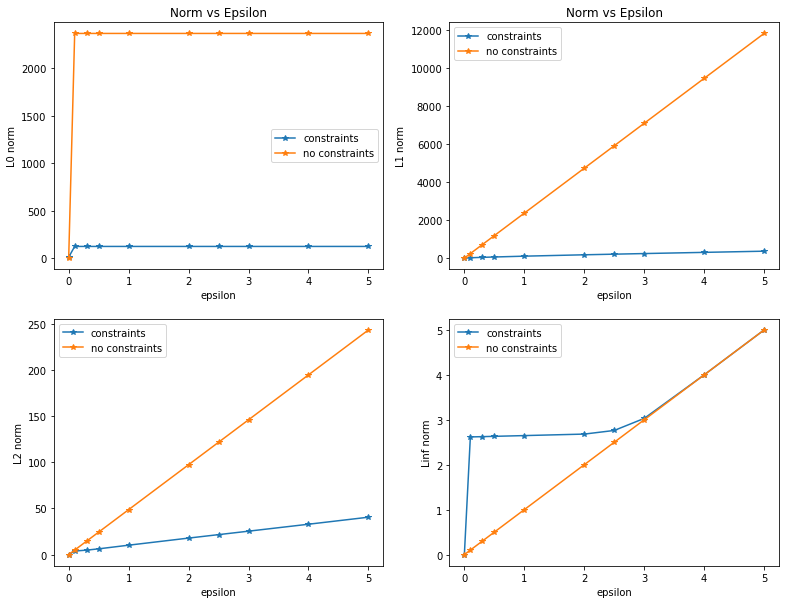

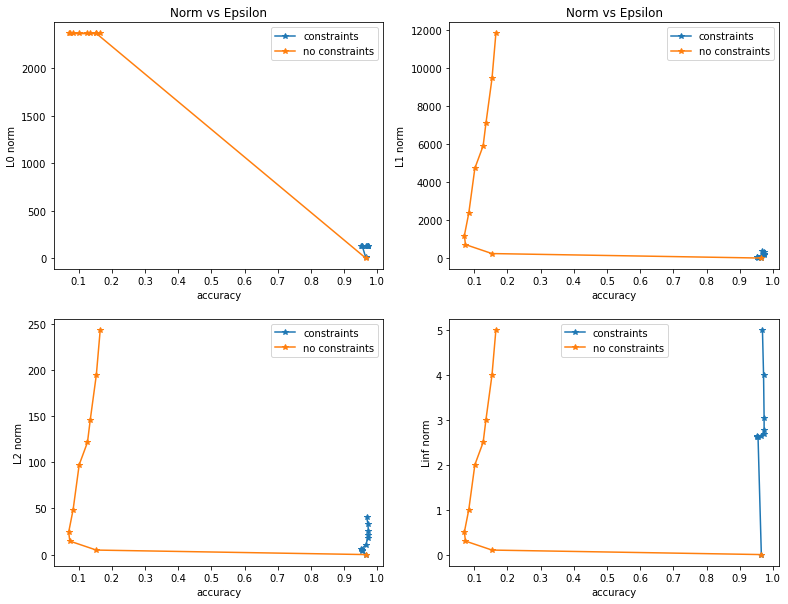

In [10]:
plots.plot_norm(epsilons, epsilons, norms_mask, norms_no_mask, "epsilon", ["constraints", "no constraints"])
plots.plot_norm(accuracies_mask, accuracies, norms_mask, norms_no_mask, "accuracy", ["constraints", "no constraints"])

In [11]:
eps_index = 9

In [12]:
benign, malicious, percentages = evaluation.calculate_shares(examples_mask[eps_index])
df_absolute, df_percentage = evaluation.create_dfs_swaps(benign, malicious, percentages)
display(df_absolute)
display(df_percentage)

,Meaning,Field in list,no of samples
0,original benign,benign[0],300
1,original benign & predicted benign,benign[1],288
2,original benign & predicted benign & attack predicted benign,benign[3],285
3,original benign & predicted benign & attack predicted malicious,malicious[3],3
4,original benign & predicted malicious,malicious[1],12
5,original benign & predicted malicious & attack predicted benign,benign[4],2
6,original benign & predicted malicious & attack predicted malicious,malicious[4],10
7,original malicious,malicious[0],300
8,original malicious & predicted benign,benign[2],9
9,original malicious & predicted benign & attack predicted benign,benign[5],6


,Proportion of samples which are,among samples which are,percentage
0,predicted benign,original benign,96.00
1,predicted malicious,original benign,4.00
2,predicted benign,original malicious,3.00
3,predicted malicious,original malicious,97.00
4,attack predicted benign,original benign & predicted benign,98.96
5,attack predicted malicious,original benign & predicted benign,1.04
6,attack predicted benign,original benign & predicted malicious,16.67
7,attack predicted malicious,original benign & predicted malicious,83.33
8,attack predicted benign,original malicious & predicted benign,66.67
9,attack predicted malicious,original malicious & predicted benign,33.33
